__Assignment 2__ <br>
Danil Redko <br>
1002572236


__Question 1__: Implement seam carving:

In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_gradient_magnitude
from scipy.ndimage import sobel, generic_gradient_magnitude
from scipy import signal
import math
import cv2

In [2]:
def my_plot(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
def G_M(grad):
    
    M = grad.copy()
    
    r,c = grad.shape
    
    for i in range(1, r):
        for j in range(0,c):
            if j<1:
                min_num = np.min(M[i-1, 0:2])
            else:
                min_num = np.min(M[i-1, j-1:j+2])
            
            M[i,j] = grad[i, j] + min_num      
    return M 

In [4]:
def find_path(M):
    
    min_arg = np.argmin(M[-1])
    
    delete_arg = []
    
    delete_arg.append([M.shape[0]-1, min_arg])
    
    
    for i in range(M.shape[0]-1, 0 ,-1):
         
        if min_arg < 1:

            min_arg = np.argmin(M[i-1, 0:2])
        else:
            min_arg = min_arg-1 + np.argmin(M[i-1, min_arg-1: min_arg+2])

        delete_arg.append([i-1, min_arg])
        
    return np.array(delete_arg)
    

In [5]:
def grad_mag(img):
    img = img.astype('float32')
    eng = generic_gradient_magnitude(img, sobel)
    #eng = gaussian_gradient_magnitude(img, 2)
    return eng

In [6]:
def find_seam(image):
   
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image_grad = grad_mag(image)
    M = G_M(image_grad)
    delete_arg = find_path(M)
    
    return delete_arg

In [7]:
def plot_seam(image, delete_arg):
    plt.plot(delete_arg[:,[0]] ,delete_arg[:,[1]], c='red')
    #plt.imshow(image)
    #plt.show()

In [8]:
def remove_seam(delete_arg, img):
    r,c, _ = img.shape
    i = 0
    mask = np.ones(img.shape, dtype=bool)
    for j in delete_arg[:,[1]]:
        mask[i, j[0], :]=False
        i+=1
    img = img[mask]
    return img.reshape(r,c-1,3)

In [9]:
def get_new_image(image1rbg):
    
    delete_arg = find_seam(image1rbg)
    
    plot_seam(image1rbg, delete_arg)
    
    return remove_seam(delete_arg, image1rbg)
    

In [10]:
def delete_columns(img, n):
    for i in range(n):
        new_image = get_new_image(img)
        img = new_image
    return img

In [11]:
image1 = cv2.imread('image2.jpg', 0)
image1rbg = cv2.imread('image2.jpg', 1)[:,:,::-1]

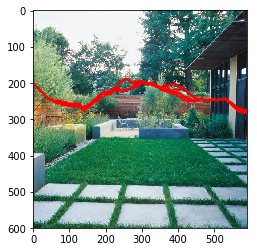

In [12]:
new_image=delete_columns(image1rbg, 10)
plt.imshow(image1rbg)

In [13]:
print(image1rbg.shape) # shape before

(600, 589, 3)


In [14]:
print(new_image.shape) #shape after

(600, 579, 3)


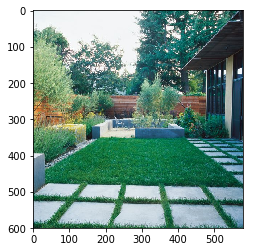

In [15]:
plt.imshow(new_image) # plot new image

In [16]:
from skimage.feature import peak_local_max

__[Question 2]__ 
<br> __a)__

Implement a function to perform Harris corner detection.

In [17]:
def find_corner(img, alpha, threshold, min_dist):
    
    
    if len(img.shape) == 3:
        img = img.mean(axis=2)
        
    img = ndimage.gaussian_filter(img, 1)
    
    r, c = img.shape
        
    dy = ndimage.sobel(img, axis=1, mode='constant')
    
    dx = ndimage.sobel(img, axis=0, mode='constant')
    
    Ixx = np.square(dx)
    
    Iyy = np.square(dy)
    
    Ixy = dy * dx
    
    wIxx = np.zeros((r,c))
    wIyy = np.zeros((r,c))
    wIxy = np.zeros((r,c))
    traceM = np.zeros((r,c))
    detM = np.zeros((r,c))
    R = np.zeros((r,c))
    
    for y in range(1, r):
        
        for x in range(1,c):
            
            wIxx[y,x] = Ixx[y-1:y+1,x-1:x+1].sum()
            wIyy[y,x] = Iyy[y-1:y+1,x-1:x+1].sum()
            wIxy[y,x] = Ixy[y-1:y+1,x-1:x+1].sum()
            traceM[y,x] = wIxx[y,x] + wIyy[y,x]
            detM[y,x]= wIxx[y,x]*wIyy[y,x]- wIxy[y,x]*wIxy[y,x]
            R[y,x] = detM[y,x] - alpha*(traceM[y,x]**2)
            
    coordinates = peak_local_max(R, min_distance=10, threshold_rel=threshold)
    
    return coordinates

In [18]:
def show_corners(img, alpha, thres, min_dist):
    
    coordinates = find_corner(img, alpha, thres, min_dist)
        
    plt.imshow(img)
    
    plt.scatter(coordinates[:, 1], coordinates[:, 0], c='r')
    
    plt.show()

In [19]:
image4 = cv2.imread('building.jpg', 1)[:,:,::-1]

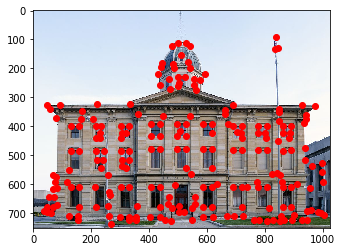

In [20]:
show_corners(image4, 0.05, 0.001, 7)

__[Question 2]__<br>Implement a function for Lowe's scale-invariant interest point detection. Let
the number of scales per octave be a parameter of your code.<br>__c)__

In [31]:
from skimage.feature import blob_dog
from skimage.transform import pyramid_gaussian
from scipy.ndimage.filters import gaussian_filter

In [32]:
image4 = cv2.imread('building.jpg', 0)

In [33]:
image4.shape

(751, 1024)

In [59]:
def interest_point(image, num_octave, s, num_layers):
    
    k = 2**0.5
    
    final_sigma_all = np.zeros((1,))
    coordinates_all = np.zeros((1,2))
    
    pyramid = list(pyramid_gaussian(image, downscale=2, max_layer=num_octave, sigma=k))
    
    for par in pyramid:
        
        layers = []
        layers.append(par)
        sigmas = []
        sigmas.append(s)
        for i in range(1, num_layers):
            sigma_item = (k**i)*s
            sigmas.append(sigma_item)
            layer=gaussian_filter(par, sigma=sigma_item)            
            layers.append(layer)
        
        layers = np.array(layers)

        dog = []
        
        for j in range(num_layers-1, 0, -1):

            dog_layer = layers[j] - layers[j-1]
            dog.append(dog_layer)
        
        dog = np.array(dog)
        
        sigmas = np.flip(np.array(sigmas), axis=0)
                
        cube_dog = np.stack(dog, axis=-1)
                         
        local_maxima = peak_local_max(cube_dog, footprint=np.ones((3,) * (image.ndim + 1)), threshold_rel=0.0, threshold_abs=0.003)
        
        sigma_ind = local_maxima[:,-1] - 1 
        
        final_sigma = sigmas[sigma_ind]
        
        coordinates = np.delete(local_maxima, 2, 1)
        
        if coordinates.shape[0] != 0:
        
            coordinates_all = np.concatenate((coordinates_all, coordinates), axis=0)
            final_sigma_all = np.concatenate((final_sigma_all, final_sigma), axis=0)

    return coordinates_all, final_sigma_all

In [60]:
def show_circles(coordinates,sigmas,img):
    ax=plt.gca()
    for i in range(0, coordinates.shape[0]):
        y, x = coordinates[i]
        r = sigmas[i]
        c = plt.Circle((x, y), r, color='r', linewidth=2, fill=False)
        ax.add_patch(c)
    plt.imshow(img)
    plt.axis('scaled')
    plt.show()

In [61]:
coord, sigmas = interest_point(image4, 5, 1, 8)

I don't know what I've done wrong.

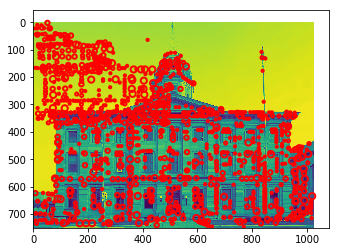

In [62]:
show_circles(coord, sigmas, image4)